In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 04 - Support Vector Machines, KNN
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [4]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_blobs, load_digits
from sklearn.metrics import euclidean_distances

from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
###------------------------------
### Hyper-paras and global params
###------------------------------

# set location of input files:
inpDir = os.path.join('Input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('Output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.20

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [6]:
def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [7]:
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

## Support Vector Machines

The line that maximizes the minimum margin.

The model class of 'hyper-planes with a margin of m' has a low VC dimension if m is big.
This maximum-margin separator is determined by a subset of the datapoints.
Datapoints in this subset  are called `support vectors`.
It will be useful computationally if only a small fraction of the datapoints are support vectors, because we use the support vectors to decide which side of the separator a test case is on.

In [8]:
#Make predictions using Support Vector Machines
from sklearn.svm import SVC
clf = SVC(kernel='linear')

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=RANDOM_STATE, cluster_std=0.60)

clf.fit(X,y)

SVC(kernel='linear')

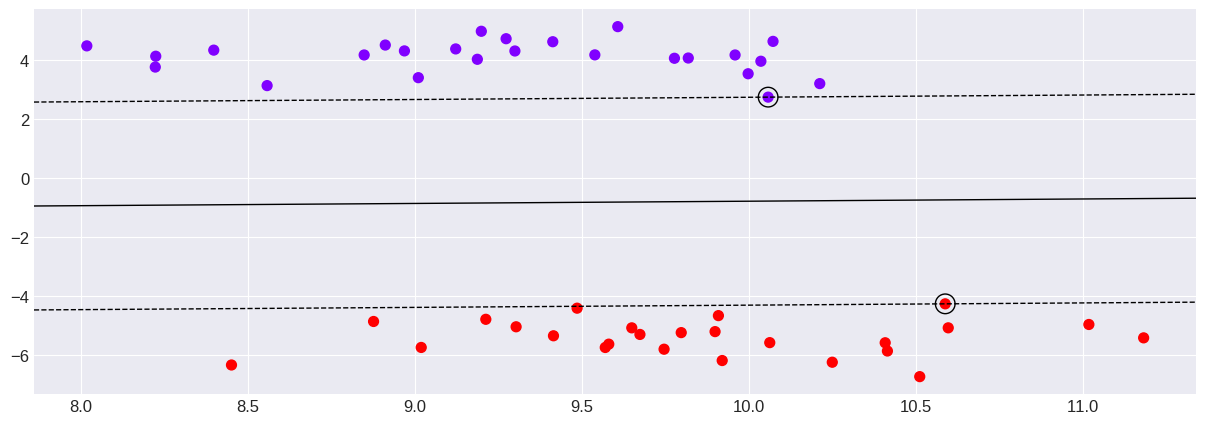

In [9]:
# plot the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=CMAP) 

# plot the decision function
fn_plot_svc_decision_function(clf);

# Plot Support vectors
plt.scatter(clf.support_vectors_[:, 0], 
            clf.support_vectors_[:, 1],
            s=200, edgecolors='k', facecolor = 'none');

The unique thing about SVM is that **only the support vectors matter**; that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!

This may seem like a trivial task, but it is a simple version of a very important concept. By drawing this separating line, we have learned a model which can **generalize** to new data. If you were to drop another point onto the plane which is unlabeled, this algorithm could now **predict** whether it's a blue or a red point.

So far we have used a linear kernel; it is also possible to use *radial basis function* kernels as well as others.

# Kernelized Support Vector Machines

## Dataset - Digits

In [10]:
# Acquire digits dataset from sklearn.datasets
digits = load_digits()

In [11]:
# What keys are available in the data
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [12]:
# whats in there?

# dataframes are easy to visualize
features_df = pd.DataFrame(digits.data, columns= digits.feature_names) 
features_df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [13]:
# get the labels as well
labels = digits.target
labels

array([0, 1, 2, ..., 8, 9, 8])

In [14]:
# what names are given
label_names = digits.target_names
label_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

NameError: name 'data_df' is not defined

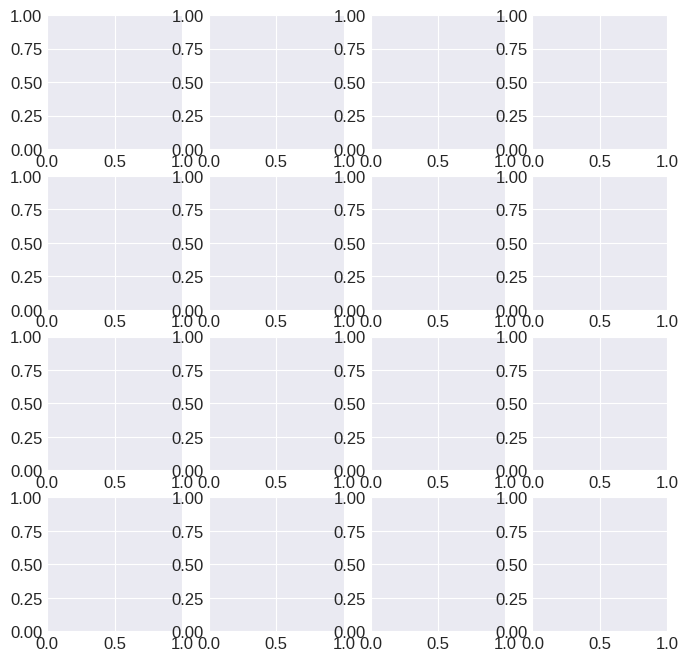

In [15]:
fig, axes = plt.subplots(4,4, figsize = (8,8)) # initialize a figure

axes = axes.ravel()

plot_df = data_df.sample(16) # sample 16 rows

for count, (key, row) in enumerate(plot_df.iterrows()):
    
    ax = axes[count] # pick an axis

    img = row.to_numpy().reshape(8,8) # reshape row to form an image
    
    ax.imshow(img, cmap = plt.cm.binary) # display image in the axis
    
    ax.axis(False) # don't show axis
    
    ax.set_title(label_names[labels[key]]) # plot the label as well

In [ ]:
# Split data in train and test sets using the TEST_SIZE
X_train, X_test, y_train, y_test = train_test_split( features_df, labels,
                                                    stratify= labels, 
                                                    random_state=RANDOM_STATE)

## F-1 Score

### Precision

Precision is the number of true positive predictions divided by the sum of true positives and false positives. It represents the accuracy of positive predictions made by the model.

Precision = $\frac{\text{True Positives}}{\text{True Positives + False Positives}}$

### Recall
Recall is the number of true positive predictions divided by the sum of true positives and false negatives. It represents the ability of the model to capture all the positive instances in the dataset.

Recall =  $\frac{\text{True Positives}{\text{True Positives + False Negatives}}

### F1- Score
The formula for calculating the F1 score is as follows:

$F1 = \frac{\text{2 * Precision * Recall}}{\text{Precision + Recall}}$​
 
The **F1 score** ranges from 0 to 1, where a higher value indicates better performance. A perfect classifier would have an F1 score of 1, while a classifier that fails to make correct positive predictions or capture positive instances would have an F1 score of 0.

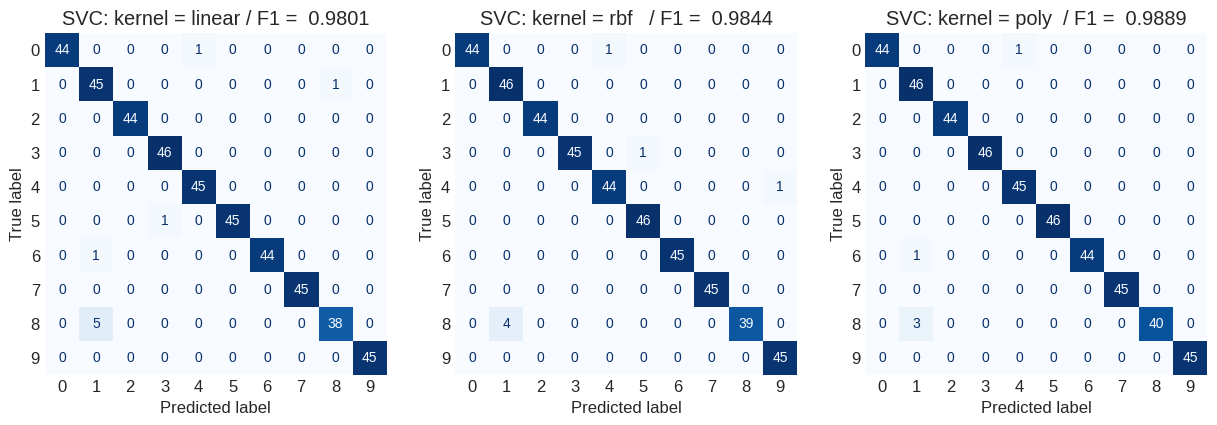

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (15,8))

for i, kernel in enumerate(['linear', 'rbf', 'poly']):

    clf = SVC(kernel=kernel).fit(X_train, y_train) # initialize and train
    
    y_pred = clf.predict(X_test) # make a prediction
    #print("SVC: kernel : {: <7}".format(kernel), end = ' | ')
    #print("F1 Score : {: .4f}".format(  ) )

    f1 = f1_score( y_test, y_pred, average='weighted') # calculate f1
    
    cm = confusion_matrix(y_test, y_pred) # calculate confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names) # display

    disp.plot(ax = axes[i], cmap=plt.cm.Blues, colorbar=False);
    
    axes[i].set_title("SVC: kernel = {0: <5s} / F1 = {1: .4f}".format(kernel, f1))
    
    axes[i].grid()

plt.show()

In [ ]:
X, y = make_blobs(centers=4, random_state=RANDOM_STATE)
y = y % 2

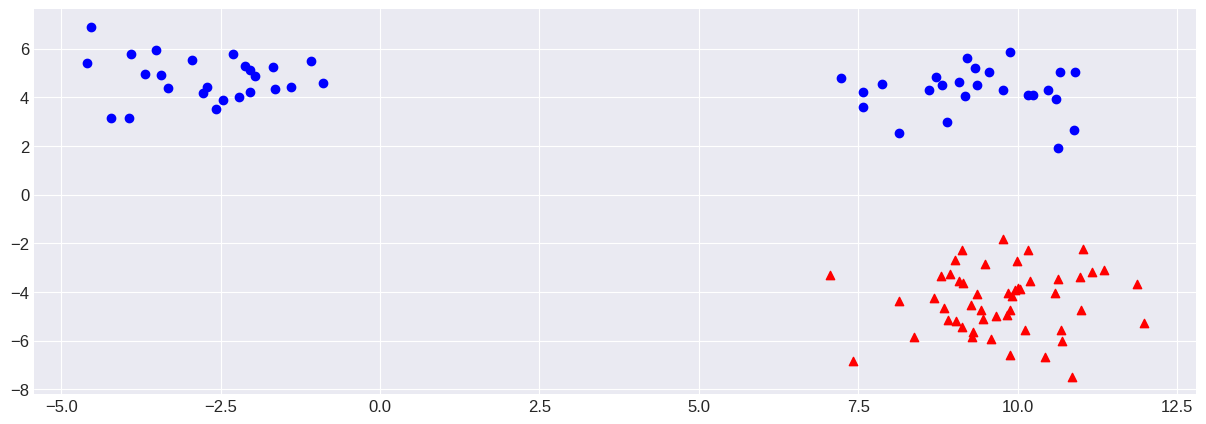

In [ ]:
fig, ax = plt.subplots()

mask = y == 0

ax.scatter(X[mask,0], X[mask,1], c = 'b')
ax.scatter(X[~mask,0], X[~mask,1], c = 'r', marker='^')

plt.show()

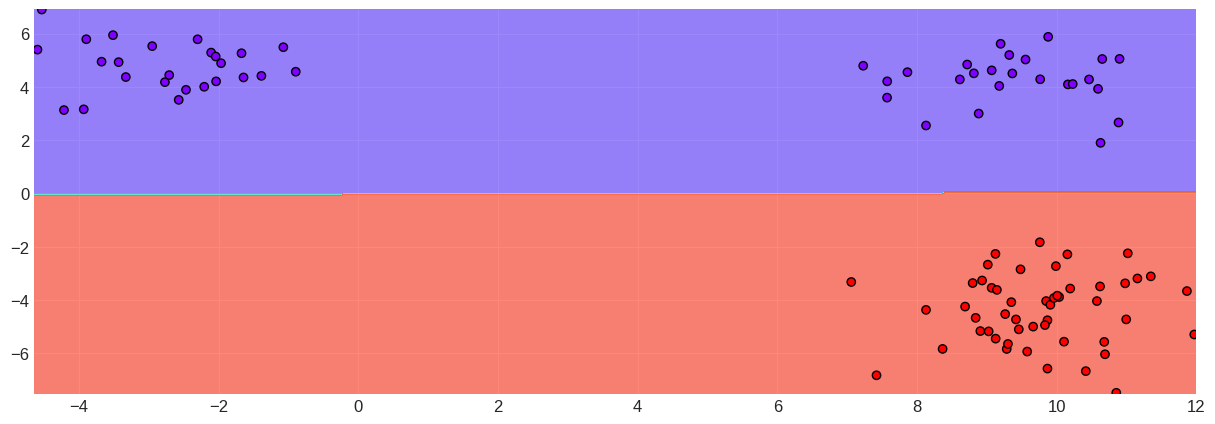

In [ ]:
linear_svm = LinearSVC(dual = 'auto', random_state=RANDOM_STATE).fit(X, y)

fn_plot_decision_boundary(linear_svm, X, y)

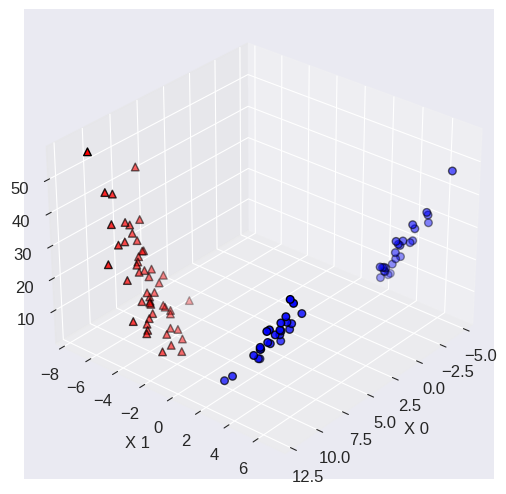

In [ ]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d

ax = plt.figure().add_subplot(projection='3d')

# plot first all the points with y==0, then all with y == 1
mask = y == 0

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=30, edgecolor='k')

ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=30, edgecolor='k')

ax.set_xlabel("X 0")

ax.set_ylabel("X 1")

ax.set_zlabel("X 1 ** 2")

# change the view point
ax.view_init(elev=30, azim=40, roll=0);

plt.tight_layout()

plt.show()

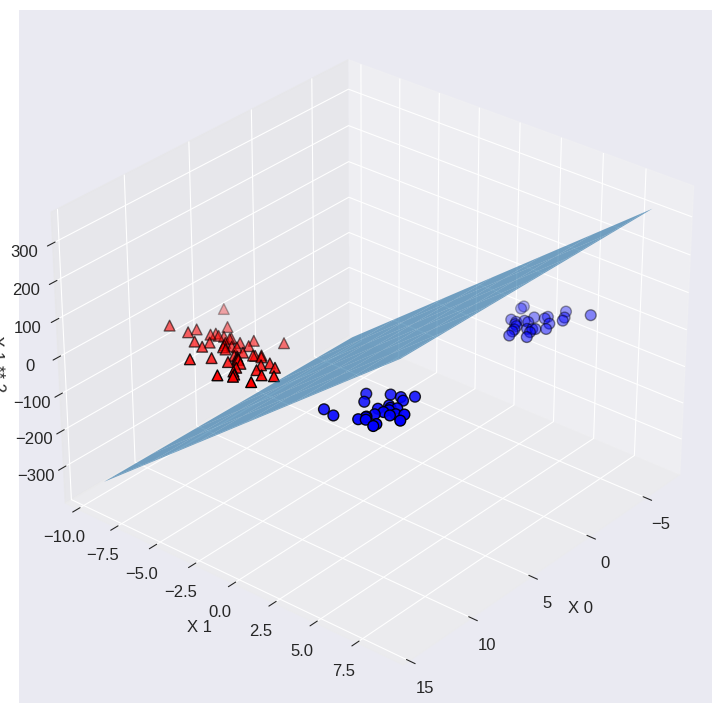

In [ ]:
linear_svm_3d = LinearSVC(dual='auto', random_state=RANDOM_STATE).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')

xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)

ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.6)

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60, edgecolor='k')

ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
         s=60, edgecolor='k')

ax.set_xlabel("X 0")

ax.set_ylabel("X 1")

ax.set_zlabel("X 1 ** 2")

# change the view point
ax.view_init(elev=30, azim=40, roll=0);

In [ ]:
# a carefully hand-designed dataset lol
X, y = make_blobs(centers=2, random_state=4, n_samples=30)

y[np.array([7, 27])] = 0

mask = np.ones(len(X))

mask = np.ma.make_mask(mask)

mask[np.array([0, 1, 5, 26])] == 0

X, y = X[mask], y[mask]

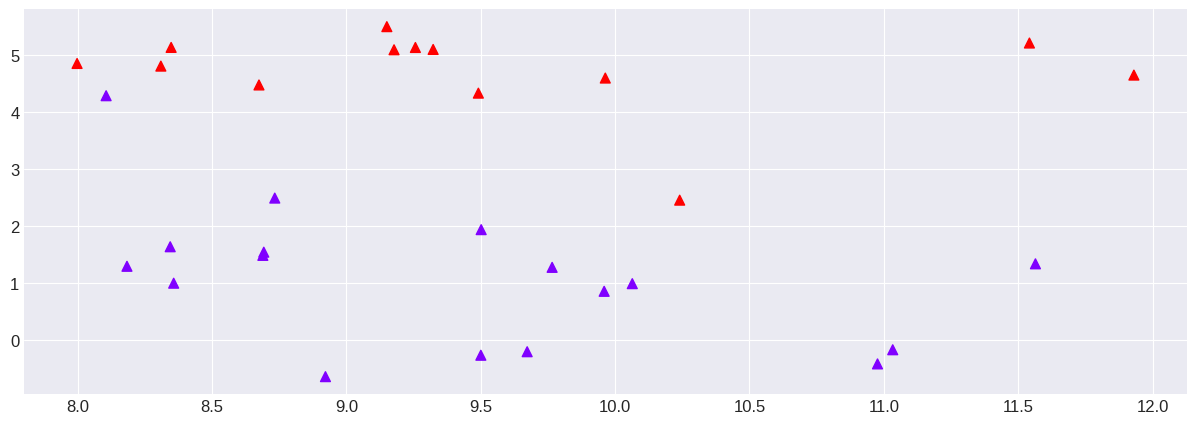

In [ ]:
fig, ax = plt.subplots()

mask = y==1

ax.scatter(X[:, 0], X[:, 1], c = y, marker='^', s = 50, cmap = CMAP);

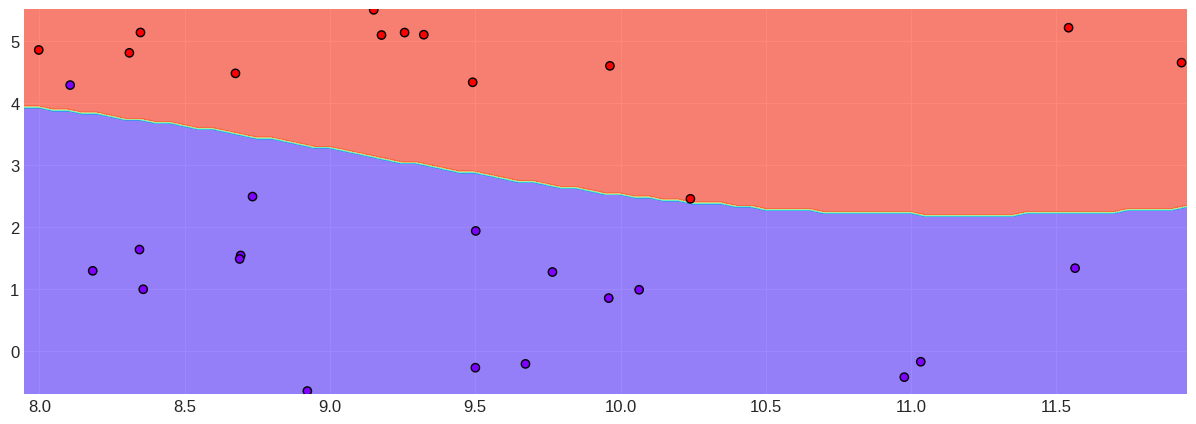

In [ ]:
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

fn_plot_decision_boundary(svm, X, y)

## DataSet

<div>
<img src = '../../images/iris.png' width='900 px' align ='left'>
<img src = '../../images/iris_petal_sepal.png' width='400 px',  align ='right'>
</div>

1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Attribute Information:

   a. sepal length in cm
   
   b. sepal width in cm
   
   c. petal length in cm
   
   d. petal width in cm
   
   e. class:
      - Iris Setosa
      - Iris Versicolour
      - Iris Virginica
      
      
4. Missing Attribute Values: None
5. Class Distribution: 33.3% for each of 3 classes.


In [ ]:
# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names

iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, 
                      header=None, names = iris_features)

target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
iris_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petal length,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petal width,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0


## Feature Extraction

Extract features and labels from the dataframe.

**Remember:** We can use only numerical values in the features and labels. Incidentally, Iris dataset contains numerical values only.

In [ ]:
features = iris_df.drop('target',axis=1)
labels = iris_df['target']

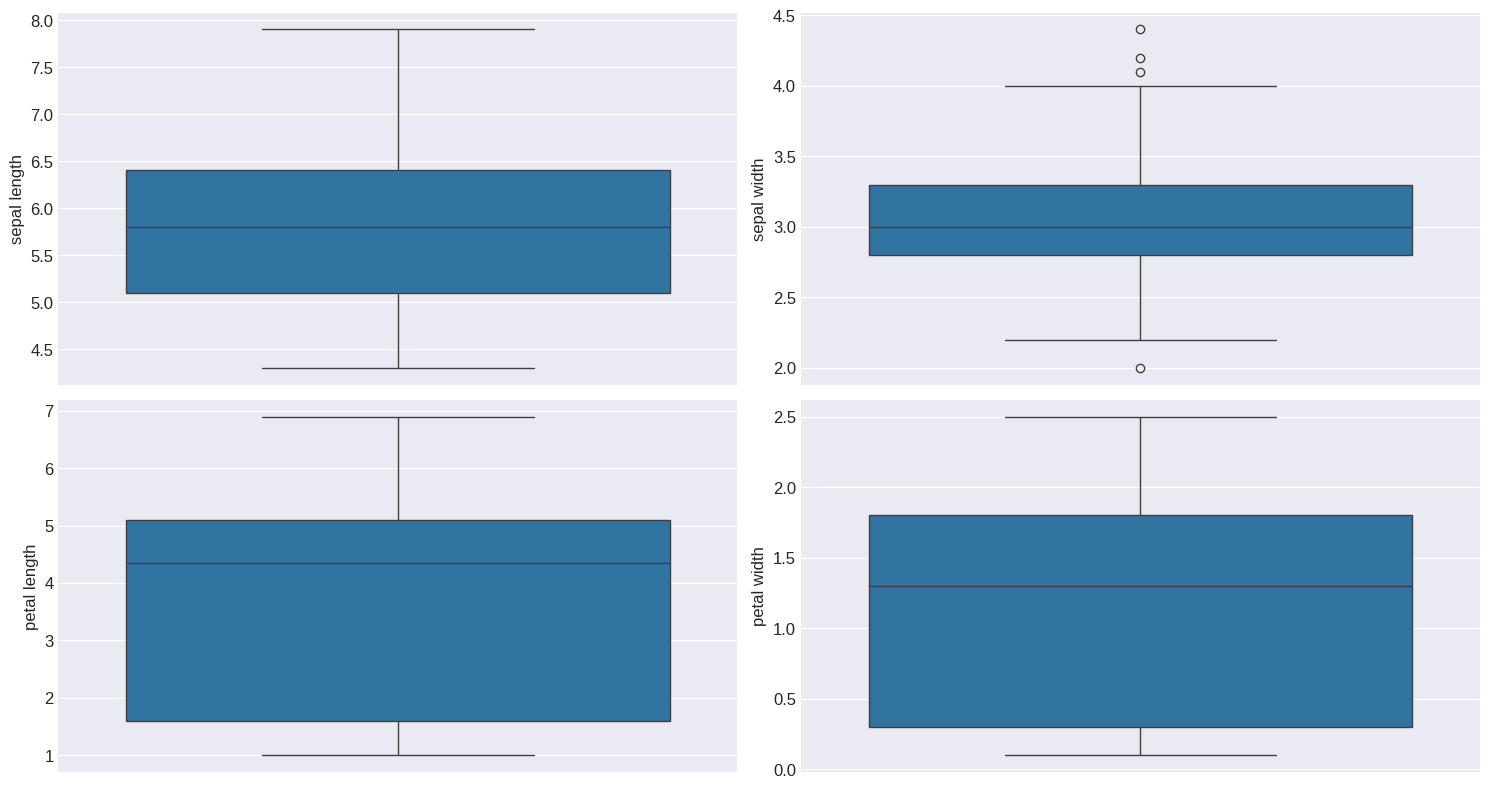

In [ ]:
## Ploting Boxplot to see the data

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))

axes = axes.flatten()

for count, col in enumerate(features.columns):
    ax = axes[count]
    
    sns.boxplot(y=col, data=features, ax=ax)

 
plt.tight_layout();


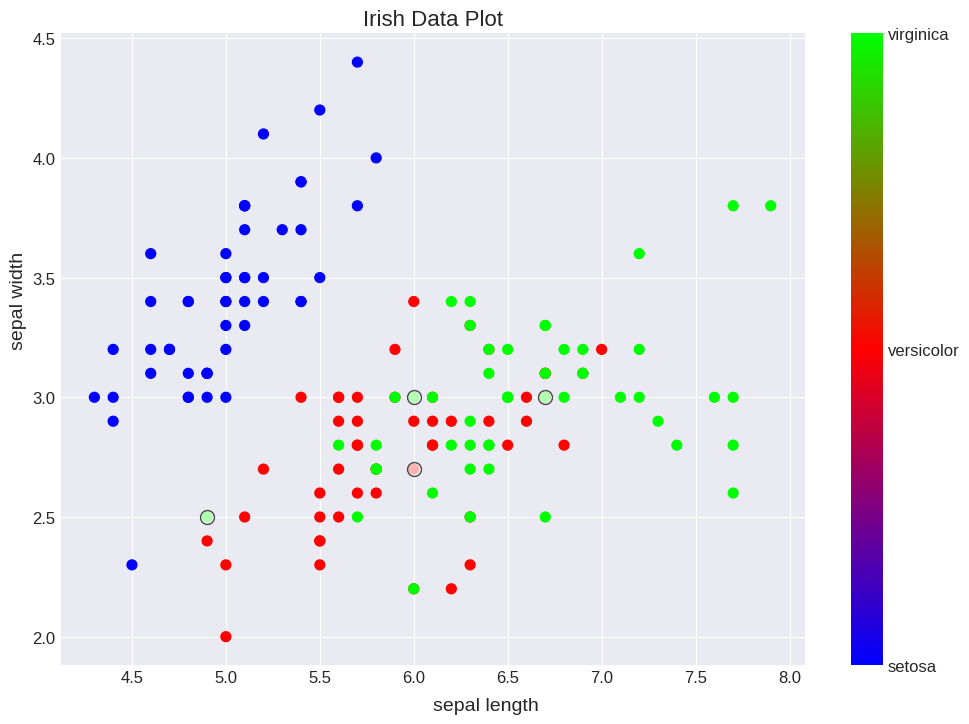

In [ ]:
# Retrain our classifier on full data set
clf = SVC(kernel='rbf')
clf.fit(features, labels)

y_pred = clf.predict(features)

# Create a figure of given size
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Irish Data Plot'
xplot = iris_df.keys()[0]
yplot = iris_df.keys()[1]

# also locate the errors in prediction
x_err = iris_df[xplot][(labels != y_pred)]
y_err = iris_df[yplot][(labels != y_pred)]

plt.scatter( iris_df[xplot], iris_df[yplot], s= 50, c=iris_df['target'], cmap=plt.cm.brg)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.scatter(x_err, y_err, color = "w", label="mismatch", s = 100, alpha=0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 # Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(xplot, fontsize=14,  ha='left') 
ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

## Parameter Tuning
Support vector Machines have a number of tunable parameters. Frequently used ones are :
- Kernel
- C
- Gamma

So, far we have used only kernal = 'linear' which uses “one-against-one” approach (Knerr et al., 1990). Other kernals are ‘poly’, ‘rbf(Radial Basis Function)’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used..

In [ ]:
# For convenience, create a function to plot
def plot_hyplane(classifier, features, labels, i):
    plt.subplot(1, 3, i )
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    pred = classifier.predict(features)
    
    x_min, x_max = features[:, 0].min() - .1, features[:, 0].max() + .1
    y_min, y_max = features[:, 1].min() - .1, features[:, 1].max() + .1

    xx, yy = np.meshgrid ( np.linspace ( x_min, x_max, 1000 ),
                       np.linspace ( y_min, y_max, 1000))
    Z = classifier.predict ( np.c_[ xx.ravel(), yy.ravel()])

    # Plot the decision surface
    Z = Z.reshape( xx.shape )
    plt.grid(False)
    plt.pcolormesh(xx, yy, Z, cmap = plt.cm.Set3 ) # refer http://matplotlib.org/users/colormaps.html

    # Plot also the training points
    plt.scatter( features [ :, 0], features [ :, 1], c = labels,
            cmap=plt.cm.flag)

    plt.axis('tight')

### PCA

*PCA will be discussed in detail.*

No of features are not very high, we may have used it as it is. However for ease of plotting, let's reduce the features to 2.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

### C Value
Let's try to plot using three values of **C ; 0.001, 1, 1000** with linear Kernel.

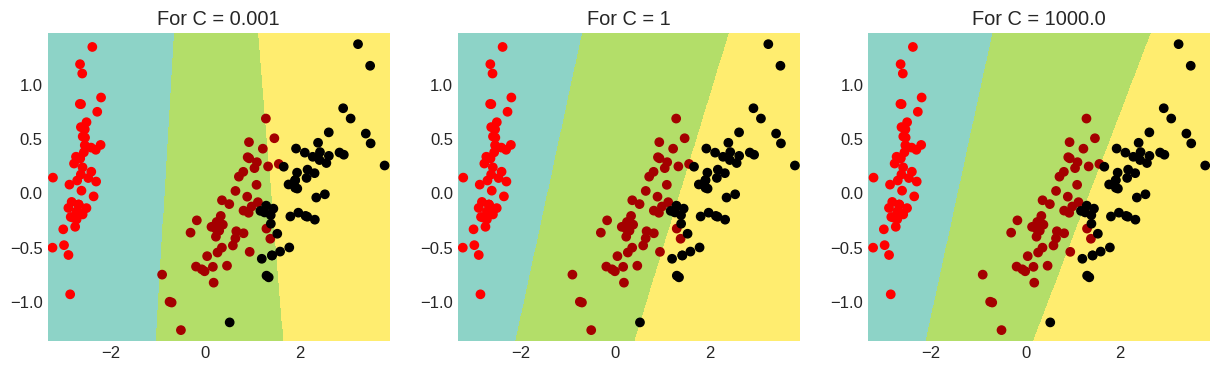

In [ ]:
plt.figure( figsize = (15,4) )
C_values = [1e-3, 1, 1e3]

i = 1

for C in C_values:
    clf = SVC(kernel='linear', C = C)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title('For C = {}'.format(C))
    
#plt.savefig('../images/22_svm_C.jpg')
plt.show()

## Kernel
We will be trying three kernels:
- Linear gives linear decision frontiers. It is the most computationally efficient approach and the one that requires the least amount of data.
- rbf uses 'radial basis functions' centered at each support vector to assemble a decision frontier. The size of the RBFs, that ultimately controls the smoothness of the decision frontier. RBFs are the most flexible approach, but also the one that will require the largest amount of data.
- poly gives decision frontiers that are polynomial. The order of this polynomial is given by the 'order' argument.

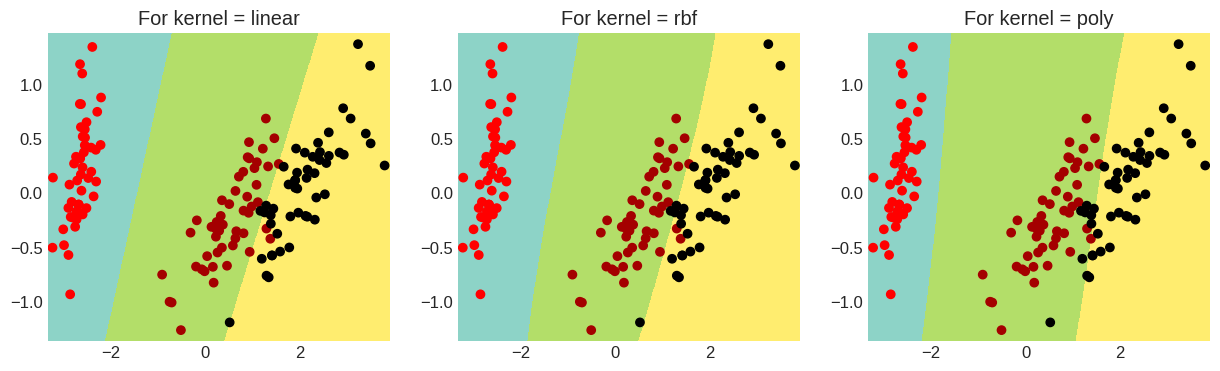

In [ ]:
plt.figure( figsize = (15,4) )
kernels = ['linear', 'rbf', 'poly']

i = 1

for k in kernels:
    clf = SVC(kernel=k)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title('For kernel = {}'.format(k))
    plt.axis('tight')
#plt.savefig('../images/22_svm_kernel.jpg')
plt.show()

## Gamma
We will be using three values of **Gamma ; 0.001, 1 and auto**

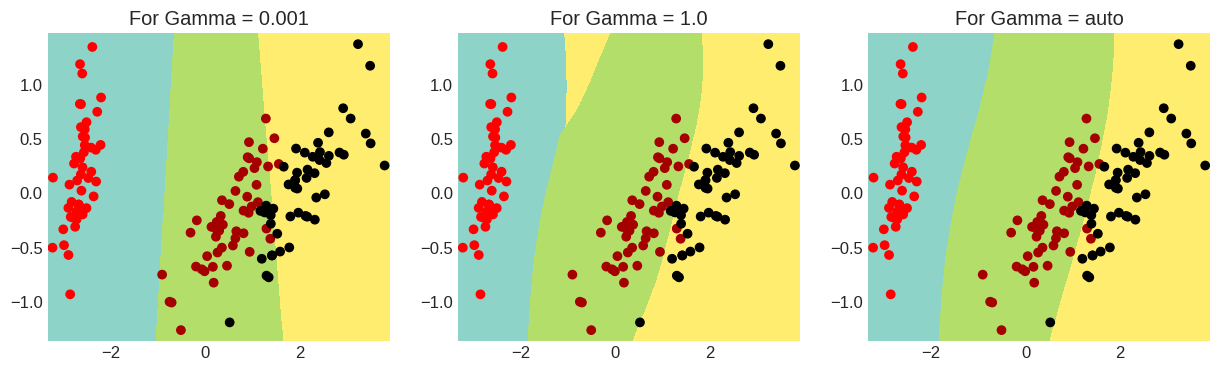

In [ ]:
plt.figure( figsize = (15,4) )
gammas = [1e-3, 1.0, 'auto']

i = 1

for g in gammas:
    clf = SVC(kernel='rbf', gamma = g)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title( 'For Gamma = {}'.format(g))
    plt.axis('tight')
#plt.savefig('../images/22_svm_gamma.jpg')
plt.show()

## K Neighbors Classifier

Using Iris dataset

In [ ]:
labels

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=1)

clf.fit(features, labels)

y_pred = clf.predict(features)

print(np.all(labels == y_pred))

True


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels, y_pred))

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


### A better representation

In [ ]:
# helper function

def plot_knn_classification(X_train, y_train, X_test, n_neighbors=1):
    
    dist = euclidean_distances(X_train, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=clf.predict(X_test), marker = '*', cmap=CMAP)
    plt.scatter(X_train[:,0], X_train[:,1], s=30, c=y_train, marker = 'o', cmap=CMAP)

    #test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], clf.predict(X_test), markers="*")
    #training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points, ["training class 0", "training class 1",
                                               "test pred 0", "test pred 1"])

In [ ]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels,
                                                    stratify=labels,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(112, 4) (112,) (38, 4) (38,)


In [ ]:
# scale our data
sc = StandardScaler()

###--------------------------------
### always:
###   fit_transform train data and
###   transform only test data
###-------------------------------
sc.fit(X_train) # learn parameters from training data
X_s_train = sc.transform(X_train) # transform train set
X_s_test = sc.transform(X_test)    # transform test set

lda = LinearDiscriminantAnalysis(n_components=2)

X_train2 = lda.fit_transform(X_s_train, y_train)

X_test2 = lda.transform(X_s_test)

In [ ]:
n_neighbors = 1

clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

In [ ]:
dist = euclidean_distances(X_train2, X_test2)
closest = np.argsort(dist, axis=0)

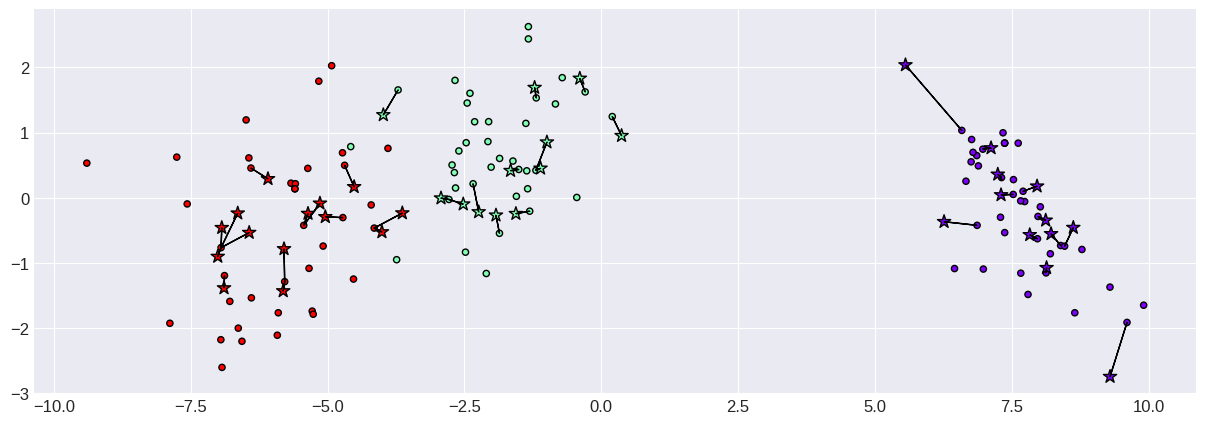

In [ ]:
# Lets Plot the data
plt.scatter(X_train2[:,0], X_train2[:,1], s=20, c=y_train, cmap = CMAP, edgecolors='k')
plt.scatter(X_test2[:,0], X_test2[:,1], s=100, marker ='*', c=y_pred, edgecolors='k', cmap = CMAP)
for x, neighbors in zip(X_test2, closest.T):
    for neighbor in neighbors[:n_neighbors]:
        plt.arrow(x[0], x[1], X_train2[neighbor, 0] - x[0],
                  X_train2[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

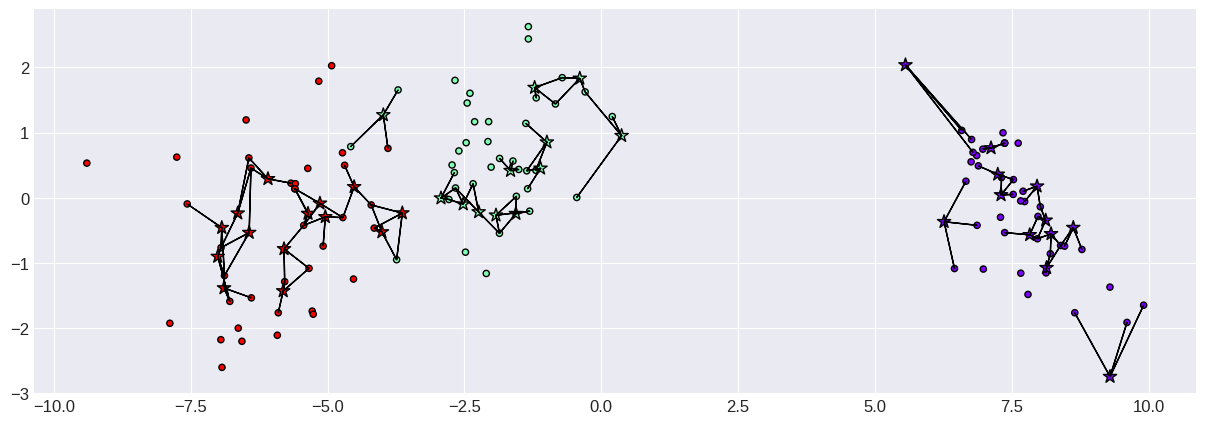

In [ ]:
n_neighbors = 3

clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

# Lets Plot the data
plt.scatter(X_train2[:,0], X_train2[:,1], s=20, c=y_train, cmap = CMAP, edgecolors='k')
plt.scatter(X_test2[:,0], X_test2[:,1], s=100, marker ='*', c=y_pred, edgecolors='k', cmap = CMAP)
for x, neighbors in zip(X_test2, closest.T):
    for neighbor in neighbors[:n_neighbors]:
        plt.arrow(x[0], x[1], X_train2[neighbor, 0] - x[0],
                  X_train2[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

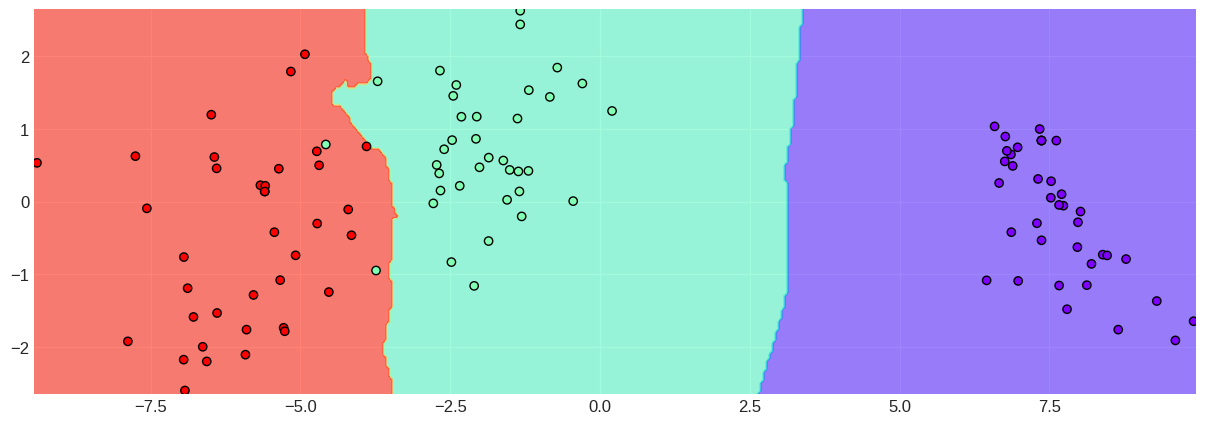

In [ ]:
fn_plot_decision_boundary(clf, X_train2, y_train)

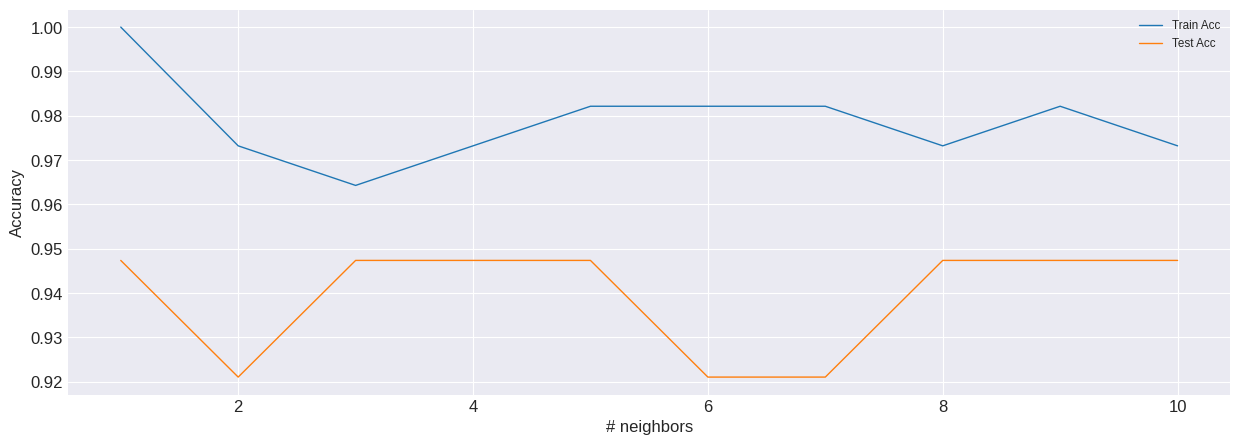

In [ ]:
training_accuracy = []
test_accuracy = []

# try n_neighbors from 1 to 10

for n_neighbors in range(1, 11):
    
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    clf.fit(X_train, y_train)
    
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

fig, ax = plt.subplots()
ax.plot(range(1, 11), training_accuracy, label="Train Acc")
ax.plot(range(1, 11), test_accuracy, label="Test Acc")
ax.set_ylabel("Accuracy")
ax.set_xlabel("# neighbors")
ax.legend();